In [ ]:
# be sure to install all requirements in ../requirements.txt, including:
! pip install jupyter_innotater

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-shzcdg98
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-shzcdg98
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=fd0357b08aedf40e8f6e4a28e23087e7bb82b77ea78a071a499ad3c376f46fc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddz7_jpp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully uninstalled clip-0.2.0


In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torch
from PIL import Image, ImageDraw
import clip
import os
import urllib.request
import zipfile
import json
from jupyter_innotater import *
import numpy as np
import tqdm

In [ ]:
model2sherlock_urlandpath = {
    'ViT-B/16': ('https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/pretrained_models/model%3DViT-B16~batch%3D512~warmup%3D500~lr%3D1e-05~valloss%3D0.0000~highlightbbox~widescreen_STEP%3D1800.pt', 'sherlock_vitb16.pt'),
    'RN50x16': ('https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/pretrained_models/model%3DRN50x16~batch%3D200~warmup%3D500~lr%3D1e-05~valloss%3D0.0000~highlightbbox~widescreen_STEP%3D4500.pt', 'sherlock_rn50x16.pt'),
    'RN50x64': ('https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/pretrained_models/model%3DRN50x64~batch%3D64~warmup%3D1000~lr%3D1e-05~valloss%3D0.0000~highlightbbox~widescreen_STEP%3D15600.pt', 'sherlock_rn50x64.pt'),
    'RN50x64-multitask': ('https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/pretrained_models/model%3DRN50x64~batch%3D64~warmup%3D1000~lr%3D1e-05~valloss%3D0.0000~randomclueinfhighlightbbox~widescreen_STEP%3D25200.pt', 'sherlock_rn50x64_multitask.pt')
}

In [ ]:
## modify these parameters if you want!
np.random.seed(1)
clip_model = 'RN50x64-multitask' # you can change this to whichever in the above
assert clip_model in model2sherlock_urlandpath
batch_size_caption_features, workers_caption_features = 128, 4
candidate_limit = 1000 # can be "None"
data_directory = 'sherlock_demo_directory'
image_path = '2364638.jpg'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(os.getcwd())
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

/content


In [ ]:
# load up the model + pretrained weights
local_model_path = data_directory + '/' + model2sherlock_urlandpath[clip_model][1]

model, preprocess = clip.load(clip_model.replace('-multitask',''), jit=False)
try:
    input_resolution = model.visual.input_resolution
except:
    input_resolution = model.input_resolution

print('Getting model weights from {}'.format(model2sherlock_urlandpath[clip_model][0]))
if not os.path.exists(local_model_path):
    urllib.request.urlretrieve(model2sherlock_urlandpath[clip_model][0], local_model_path)

state = torch.load(local_model_path, map_location=device)
state['model_state_dict'] = {k.replace('module.clip_model.', '') : v for k, v in state['model_state_dict'].items()}
state['model_state_dict'] = {k.replace('clip_model.', '') : v for k, v in state['model_state_dict'].items()}
model.load_state_dict(state['model_state_dict'])
model.to(device)

100%|█████████████████████████████████████| 1.26G/1.26G [00:41<00:00, 32.7MiB/s]


Getting model weights from https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/pretrained_models/model%3DRN50x64~batch%3D64~warmup%3D1000~lr%3D1e-05~valloss%3D0.0000~randomclueinfhighlightbbox~widescreen_STEP%3D25200.pt


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)


In [ ]:
# download the validation clues/inferences to serve as candidates
data_url = 'https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/data/sherlock_val_with_split_idxs_v1_1.json.zip'
local_data_path = data_directory + '/sherlock_val_with_split_idxs_v1_1.json.zip'
if not os.path.exists(local_data_path):
    urllib.request.urlretrieve(data_url, local_data_path)

archive = zipfile.ZipFile(local_data_path, 'r')
clues, inferences = [], []
with archive.open('sherlock_val_with_split_idxs_v1_1.json',mode='r') as f:
    val = json.load(f)

all_clues = list(set([v['inputs']['clue'] for v in val]))
all_inferences = list(set([v['targets']['inference'] for v in val]))
np.random.shuffle(all_clues)
np.random.shuffle(all_inferences)
if candidate_limit:
    all_clues = all_clues[:candidate_limit]
    all_inferences = all_inferences[:candidate_limit]
print('loaded {} clues and {} inferences'.format(len(all_clues), len(all_inferences)))

loaded 1000 clues and 1000 inferences


In [ ]:
# wrapper modeling code
def clip_forward_image(model, image):
    if len(image.shape) == 5:
        im_feat1 = model.encode_image(image[:, 0, ...])
        im_feat2 = model.encode_image(image[:, 1, ...])
        image_features = (im_feat1 + im_feat2) / 2
    else:
        image_features = model.encode_image(image)

    # normalized features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return image_features


def clip_forward_text(model, text):
    text_features = model.encode_text(text)
    # normalized features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

In [ ]:
# extract the caption features
class CLIPDatasetCaption(torch.utils.data.Dataset):
    def __init__(self, captions, prefix=''):
        self.captions = captions
        self.prefix = prefix

    def __getitem__(self, idx):
        caption = clip.tokenize(self.prefix + '{}'.format(self.captions[idx]), truncate=True).squeeze()
        return {'caption': caption}

    def __len__(self):
        return len(self.captions)

if '-multitask' in clip_model:
    clue_prefix = 'clue: '
    inference_prefix = 'inference: '
else:
    clue_prefix = inference_prefix = ''

clue_iterator = torch.utils.data.DataLoader(
        CLIPDatasetCaption(all_clues, clue_prefix),
        batch_size=batch_size_caption_features, num_workers=workers_caption_features, shuffle=False)

inference_iterator = torch.utils.data.DataLoader(
        CLIPDatasetCaption(all_inferences, inference_prefix),
        batch_size=batch_size_caption_features, num_workers=workers_caption_features, shuffle=False)

all_clue_feats, all_inference_feats = [], []
with torch.no_grad():
    for c in tqdm.tqdm(clue_iterator):
        all_clue_feats.append(clip_forward_text(model, c['caption'].to(device)).cpu().numpy())
with torch.no_grad():
    for c in tqdm.tqdm(inference_iterator):
        all_inference_feats.append(clip_forward_text(model, c['caption'].to(device)).cpu().numpy())

all_clue_feats = np.vstack(all_clue_feats)
all_inference_feats = np.vstack(all_inference_feats)
clue_idx2clue = dict(enumerate(all_clues))
inf_idx2inf = dict(enumerate(all_inferences))
print('feature shape: {}, mapping length: {}'.format(all_clue_feats.shape, len(clue_idx2clue)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [08:09<00:00, 61.16s/it]

feature shape: (1000, 1024), mapping length: 1000


In [ ]:
# functions that highlight bboxes wrapped in a dataloader
class ImageHighlightBboxDataset(torch.utils.data.Dataset):
    def __init__(self, images, resolution):
        '''
        images:
            a list of [{'filepath': str, 'region': [ {'left': int, 'top': int, 'width': int, 'height':int } ]} ]
        resolution:
            the int resolution from CLIP
        '''
        self.images = images
        self.preprocess = self._transform_test(resolution)

    @staticmethod
    def highlight_region(image, bboxes):
        image = image.convert('RGBA')
        overlay = Image.new('RGBA', image.size, '#00000000')
        draw = ImageDraw.Draw(overlay, 'RGBA')
        for bbox in bboxes:
            x = bbox['left']
            y = bbox['top']
            draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                            fill='#ff05cd3c', outline='#05ff37ff', width=3)

        image = Image.alpha_composite(image, overlay)
        return image

    @staticmethod
    def _transform_test(n_px):
        return Compose([
            Resize(n_px, interpolation=Image.BICUBIC),
            CenterCrop(n_px),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    @staticmethod
    def image_to_torch_tensor(image, preprocess_fn):
        width, height = image.size
        if width >= height:
            im1 = {'height': height, 'width': height, 'left': 0, 'top': 0}
            im2 = {'height': height, 'width': height, 'left': width-height, 'top': 0}
        else:
            im1 = {'height': width, 'width': width, 'left': 0, 'top': 0}
            im2 = {'height': width, 'width': width, 'left': 0, 'top': height-width}
        regions = [image.crop((bbox['left'], bbox['top'], bbox['left'] + bbox['width'], bbox['top'] + bbox['height'])) for bbox in [im1, im2]]
        image = torch.stack([preprocess_fn(r) for r in regions], 0)
        return image

    def __getitem__(self, idx):
        c_data = self.images[idx]
        image = Image.open(c_data)
        image = self.hide_region(image, c_data['bboxes'])
        image = self.image_to_torch_tensor(image, self.preprocess)
        return {'image': image}

    def __len__(self):
        return len(self.images)

In [ ]:
## get a bounding box
targets = np.zeros((1, 4)) # Initialise bounding boxes as x,y = 0,0, width,height = 0,0
Innotater( ImageInnotation([image_path]), BoundingBoxInnotation(targets) )

Innotater(children=(HBox(children=(VBox(children=(ImagePad(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0…

In [ ]:
image = Image.open(image_path)
image_with_highlight = ImageHighlightBboxDataset.highlight_region(
    image, [{'left': targets[0, 0], 'top': targets[0, 1], 'width': targets[0, 2], 'height': targets[0, 3]}])
transform = ImageHighlightBboxDataset._transform_test(input_resolution)
image_as_tensor = ImageHighlightBboxDataset.image_to_torch_tensor(image_with_highlight, transform).unsqueeze(0)
with torch.no_grad(): image_feature_vector = clip_forward_image(model, image_as_tensor).squeeze().cpu().numpy()
image_feature_vector.shape

(1024,)

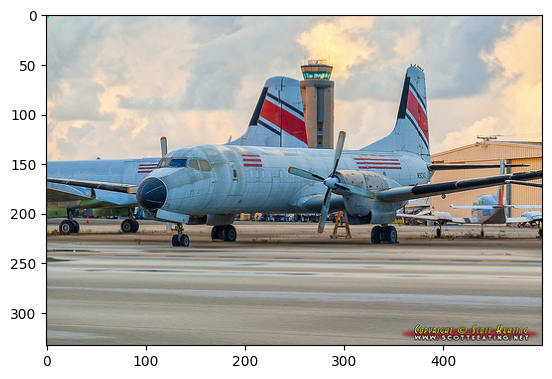

In [ ]:
matplotlib.pyplot.imshow(image_with_highlight)

In [ ]:
top_clue_idxs = np.argsort(-image_feature_vector @ all_clue_feats.transpose())[:5]
top_inf_idxs = np.argsort(-image_feature_vector @ all_inference_feats.transpose())[:5]

In [ ]:
print('Top clues (NOTE: THESE ARE UNRELIABLE EXCEPT FOR THE MULTITASK MODEL!):')
for c_idx in top_clue_idxs:
    print(clue_idx2clue[c_idx])
print()
print('Top inferences:')
for c_idx in top_inf_idxs:
    print(inf_idx2inf[c_idx])

Top clues (NOTE: THESE ARE UNRELIABLE EXCEPT FOR THE MULTITASK MODEL!):
a ladder leading up to an airplane's door
a jet airplane has plugs in the engine inlets.
a munitions crate
a man wearing an orange vest
a jet airplane has engines mounted above the high wing.

Top inferences:
The planes are jets.
This is meant to be a patriotic item, as it looks similar to the British Union Jack.
this is part of an airshow.
this is the cockpit
the lights are directing the plane
